# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

## Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

## Instalación de Librerias

In [85]:
!pip install scikit-learn==0.20.3 --upgrade

     |████████████████████████████████| 5.4 MB 399 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tpot 0.11.5 requires scikit-learn>=0.22.0, but you'll have scikit-learn 0.20.3 which is incompatible.
sklearn-pandas 2.0.0 requires scikit-learn>=0.23.0, but you'll have scikit-learn 0.20.3 which is incompatible.
kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
kmeans-smote 0.1.2 requires numpy<1.16,>=1.13, but you'll have numpy 1.18.5 which is incompatible.
imbalanced-learn 0.7.0 req

In [86]:
# Si desea utilizar la biblioteca ** xgboost **, instale la versión 0.71.
!pip install xgboost==0.71 --upgrade

     |████████████████████████████████| 494 kB 402 kB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-0.71-cp37-cp37m-linux_x86_64.whl size=1957625 sha256=e28ef57d05a92abb1441e648cba2c607e0a6082dc242593fea8d8ff04206ee8e
  Stored in directory: /root/.cache/pip/wheels/3f/49/f8/fa122a883fe4e58e72caaca1bf8ddbf4eebc3e0ca65c2f067e
Successfully built xgboost
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.2.0
    Uninstalling xgboost-1.2.0:
      Successfully uninstalled xgboost-1.2.0


In [1]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In c:\users\david\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\david\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\david\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\users\david\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import KNNImputer

class TransformData(BaseEstimator, TransformerMixin):
    def __init__(self, n_components,target):
        self.n_components = n_components
        self.target = target
        self.mean_acept = 0
        self.mean_sospe = 0
        self.min_values = 0
        self.mean_glob  = 0
        self.max_log_values = 0

    def fit(self, X, y):
        # Guardando los valores medios
        #X = X.join(y)
        columns = X.columns.tolist()
        #self.mean_glob = X.mean()
        self.knnimputer = KNNImputer(n_neighbors=4, weights="uniform")
        self.knnimputer.fit(X)
        X = self.knnimputer.transform(X)
        
        X = pd.DataFrame(data=X,columns = columns).join(y)
        
        count4bal = X[self.target].value_counts().sort_values(ascending=True)
        class_minor = count4bal.index[0]
        class_mayor = count4bal.index[-1]
        mayority_sample = count4bal[-1]
        
        df_minority_upsampled = resample(X.loc[X[self.target]==class_minor], 
                                 replace=True,     # sample with replacement
                                 n_samples=mayority_sample,    # to match majority class
                                 random_state=17) # reproducible results
        
        df_temp = pd.concat([df_minority_upsampled,X.loc[X[self.target]==class_mayor]],ignore_index=True)
        
        self.scaler0 = MinMaxScaler()
        self.scaler0.fit(df_temp[columns])
        df_temp[columns] = self.scaler0.transform(df_temp[columns])
        
        df_balanced, label = df_temp.drop(columns=[self.target ]), df_temp[self.target ]
        self.pca = PCA(n_components=self.n_components)  # df_balanced, label
        self.scaler = MinMaxScaler()
        self.pca.fit(df_balanced) ## justa para todo el espectro de datos
        self.scaler.fit(self.pca.transform(df_balanced))
        return self
    
    
    def transform(self, X ):
        df_temp = self.knnimputer.transform(X) #X.fillna(self.mean_glob)
        df_temp = self.scaler0.transform(df_temp)

        df_transformed = self.pca.transform(df_temp)
        return self.scaler.transform(df_transformed)
    
### ONLY FOR PRETRAIN NOT PIPELINE
class PreTrainData( ):
    def __init__(self,target):
        self.target = target
        self.mean_acept = 0
        self.mean_sospe = 0
        self.min_values = 0
        self.mean_glob  = 0
        self.max_log_values = 0

    def fit(self, X, minNan2drop=5):
        # Guardando los valores medios
        
        #self.mean_glob = X.mean()
        df_temp_acep = X.loc[X[self.target ]=='Aceptado'].dropna(thresh=len(X.columns)-(minNan2drop-1))
        #self.mean_acep = df_temp_acep.mean()
        
        df_temp_sosp = X.loc[X[self.target ]=='Sospechoso']
        #self.mean_sosp = df_temp_sosp.mean()
        
        #df_temp_acep = df_temp_acep.fillna(self.mean_acep) 
        #df_temp_sosp = df_temp_sosp.fillna(self.mean_sosp) 
        df_temp = pd.concat([df_temp_acep,df_temp_sosp])
        
        y = X['OBJETIVO']
        df_temp = X.drop(columns = ['OBJETIVO'])
        columns = df_temp.columns.tolist()
        self.knnimputer = KNNImputer(n_neighbors=6, weights="uniform")
        self.knnimputer.fit(df_temp)
        df_temp = self.knnimputer.transform(df_temp)
        df_temp = pd.DataFrame(data=df_temp,columns = columns).join(y)
        
        
        count4bal = df_temp[self.target].value_counts().sort_values(ascending=True)
        class_minor = count4bal.index[0]
        class_mayor = count4bal.index[-1]
        mayority_sample = count4bal[-1]
        
        df_minority_upsampled = resample(df_temp.loc[df_temp[self.target]==class_minor], 
                                 replace=True,     # sample with replacement
                                 n_samples=mayority_sample,    # to match majority class
                                 random_state=17) # reproducible results
        
        df_temp = pd.concat([df_minority_upsampled,df_temp.loc[df_temp[self.target]==class_mayor]],ignore_index=True)
        #df_temp.reset_index(inplace=True)
        print(df_temp[self.target].value_counts())
        
        return df_temp
    
import itertools
%matplotlib inline
def plot_confusion_matrix(y_true, y_pred, class_names,title="Confusion matrix",normalize=False,onehot = False, size=4):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    if onehot :
        cm = confusion_matrix([y_i.argmax() for y_i in y_true], [y_ip.argmax() for y_ip in y_pred])
    else:
        cm = confusion_matrix(y_true, y_pred)
    figure = plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2) if normalize else cm

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #return figure

### Descargando el dataset csv desde Github

In [6]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

--2020-09-04 09:08:53--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751735 (1.7M) [text/plain]
Saving to: 'reto-4-compu-train.csv'

     0K .......... .......... .......... .......... ..........  2%  297K 6s
    50K .......... .......... .......... .......... ..........  5%  771K 4s
   100K .......... .......... .......... .......... ..........  8%  810K 3s
   150K .......... .......... .......... .......... .......... 11%  842K 3s
   200K .......... .......... .......... .......... .......... 14% 3.46M 2s
   250K .......... .......... .......... .......... .......... 17% 2.45M 2s
   300K .......... .......... .......... .......... .......... 20% 1.11M 2s
   350K ........

In [9]:
df = pd.read_csv('reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
EFECTIVO                     7986 non-null float64
CXC                          7968 non-null float64
INVENTARIO                   8000 non-null float64
EQ_OFICINA                   7945 non-null float64
EQ_TRANSPORTE                7988 non-null float64
TERRENOS_Y_CONSTRUCCIONES    8038 non-null float64
CXP                          7934 non-null float64
CONTRIBUCIONES_X_PAGAR       8052 non-null float64
ANTICIPOS_CTE                7976 non-null float64
CAP_SOCIAL                   8036 non-null float64
UTILIDADES_ACUMULADAS        7993 non-null float64
UTILIDAD_O_PERDIDA           8031 non-null float64
TOTAL_VENTAS                 7941 non-null float64
TOTAL_COMPRAS                7908 non-null float64
UTILIDAD_BRUTA               7971 non-null float64
TOTAL_GASTOS                 7943 non-null float64
OBJETIVO                     9400 non-null object
dtypes: float64(16), object

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [11]:
df.describe(include=['object'])

,OBJETIVO
count,9400
unique,2
top,Aceptado
freq,8873


In [12]:
#df_local = pd.concat([df_temp_acep,df_temp_sosp])
pretraindata = PreTrainData(target = 'OBJETIVO')
df_local = pretraindata.fit(df, minNan2drop=3)
print(len(df_local['OBJETIVO']))

print("#############################")

Aceptado      8873
Sospechoso    8873
Name: OBJETIVO, dtype: int64
17746
#############################


#### Datos Nulos

In [ ]:
df_mod = df.copy() #.loc[df['OBJETIVO']=='Aceptado']
df_mod.dropna(thresh=13, inplace= True,axis=0)
df_mod.loc[df_mod['OBJETIVO']=='Aceptado'].isnull().sum(axis=0) #Sospechoso

Podemos observar que la cantidad de casos sospechosos es inferior en ~x16 a los casos aceptados, por lo que nos confirma la posibilidad de eeliminar datos sin perder datos valiosos para el análisis.<br>
Sin embargo debemos curar los datos 'Sospechosos' para no perder información

In [57]:
#df.pivot_table(index='OBJETIVO',values='OBJETIVO', aggfunc='count')
df['count_temp'] = 1
_ = pd.pivot_table(df, index= 'OBJETIVO',values= 'count_temp',aggfunc='count')
df.drop(columns=['count_temp'], inplace=True)
_

,count_temp
OBJETIVO,
Aceptado,8873
Sospechoso,527


### Observando Histogramas de las caracteristicas

Podemos observar que solo utilizando un comportamiento logaritmico en el conteo, podemos visualizar información de utilidad.

##### **Hipotesis**

* Existe una sobrepoblación de ciertos valores por lo que se podría presindir de ellos

* Es posible librarnos de la inmensa cantidad de valores nulos, con solo eliminar toda la muestra

* Para no peder muestrar del tipo 'sospechoso' es necesario curar los datos perdidos

* Se observa de los histogramas que todos los valores tiene un factor comun de 1e6 a 1e9, por lo que podemos normalizarlos sin incombenientes, para trabajar con números más interpretables

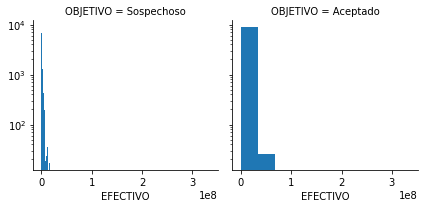

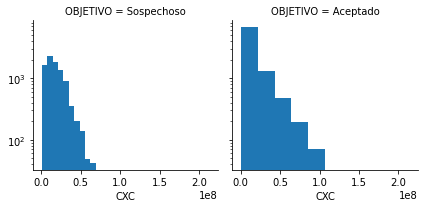

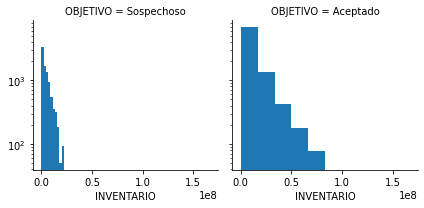

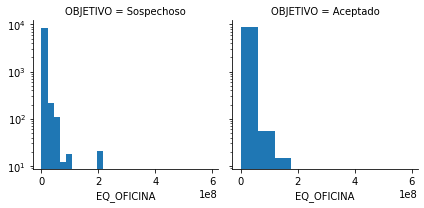

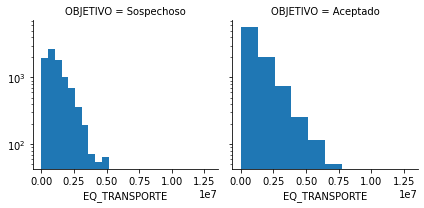

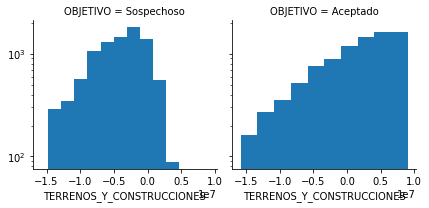

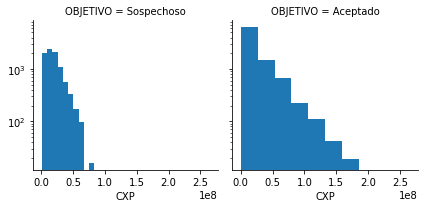

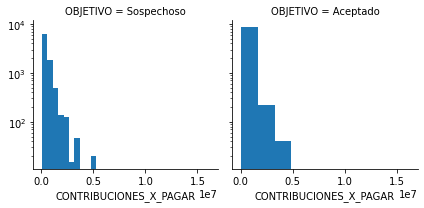

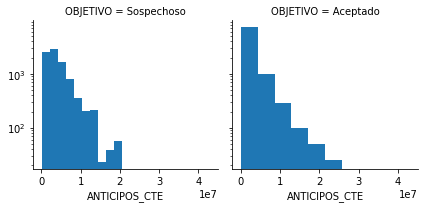

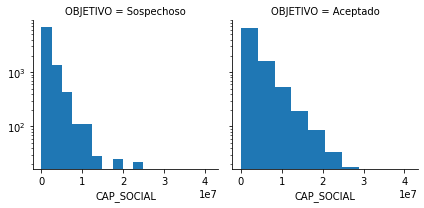

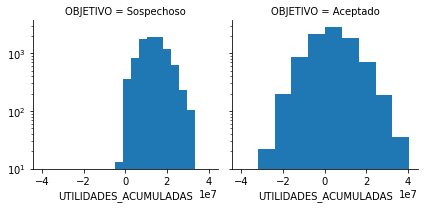

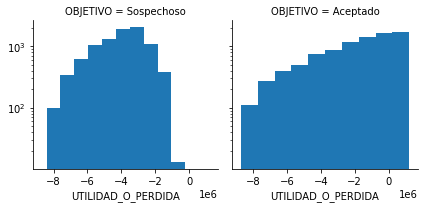

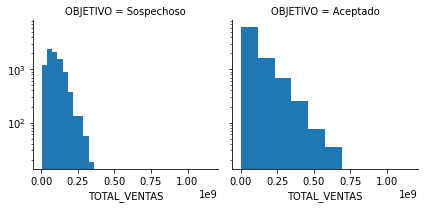

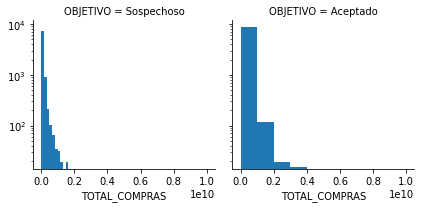

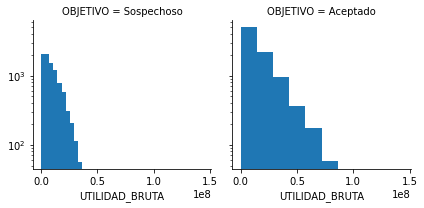

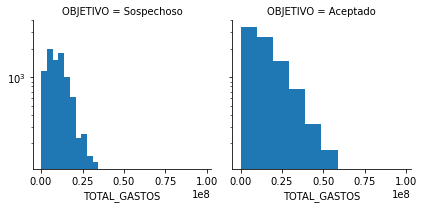

In [73]:
columns = df_local.columns.tolist()
columns.remove('OBJETIVO')
for column in columns:
    g = sns.FacetGrid(df_local[['OBJETIVO',column]], col='OBJETIVO')
    g.map(plt.hist, column, bins=None,log=True)

### Matriz de Correlación

Con la finalidad de averiguar que variables guardan correlación y en que magnitud, obtamos por evaluar la correlación existente

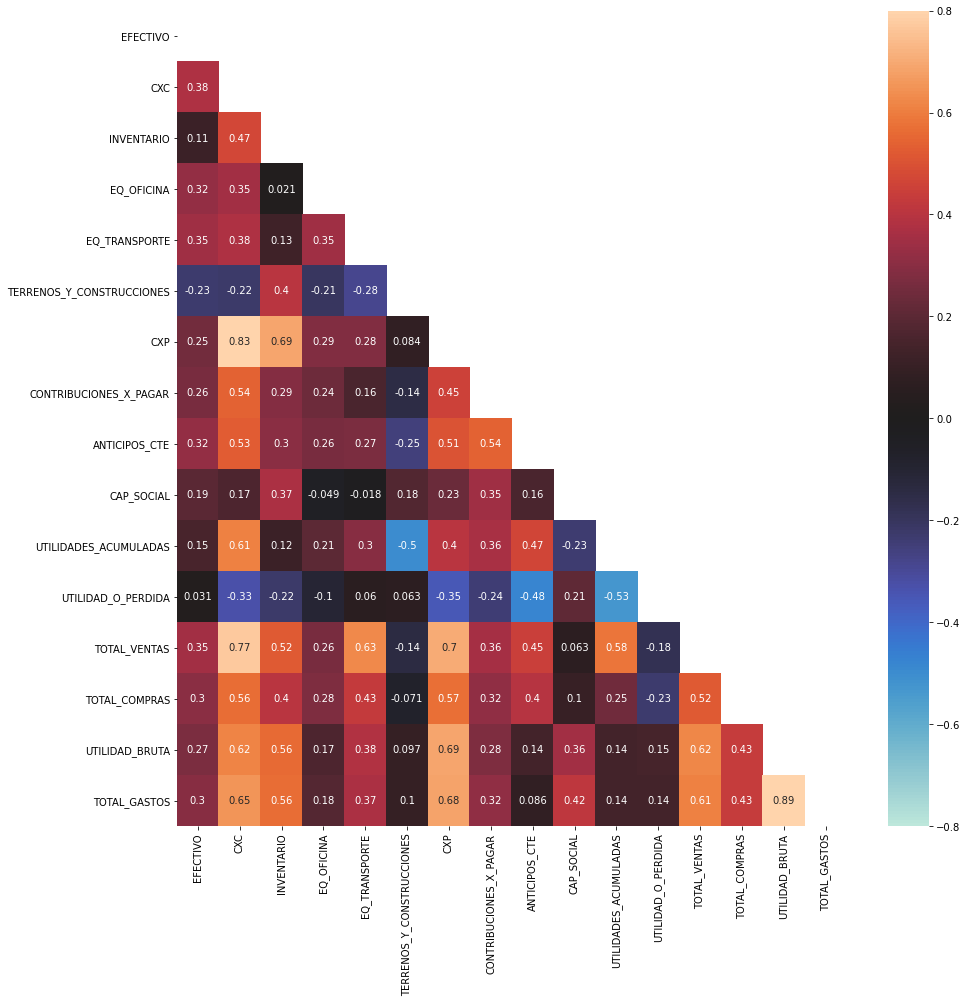

In [83]:
import seaborn as sns
# compute correlation matrix using pandas corr() function
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
corr_df = df_local.corr(method='pearson') 
matrix = np.triu(corr_df)
hmap=sns.heatmap(corr_df,annot=True, ax=ax, mask=matrix, vmin=-.8,vmax=.8, center=0)

### Feature Engineering

## Reducción de dimensionalidad

### MODEL PREDICTIC TIME

In [13]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV,StratifiedKFold
#from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier#StackingClassifier
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import svm
from sklearn.decomposition import PCA
#from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from collections import defaultdict
from sklearn.metrics import classification_report

## Parameter optimization

In [16]:
pretraindata = PreTrainData(target = 'OBJETIVO')
df_local = pretraindata.fit(df, minNan2drop=3)
print(len(df_local['OBJETIVO']))

transformData = TransformData(n_components=10,target='OBJETIVO')
transformData.fit(df_local.drop(columns=['OBJETIVO']),df_local['OBJETIVO'])

X_train       = transformData.transform( df_local.drop(columns=['OBJETIVO']) ).copy()
y_train       = df_local['OBJETIVO'].copy()


skf = StratifiedKFold(n_splits=10)
cross_cal = []
# Parameters to tune
# SVC
tuned_parameters_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 'auto','scale'],'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel':['poly'], 'degree':[3,4,5,6,7]},
                     {'kernel':['sigmoid']}]
# XGB
tuned_parameters_xgb = [{'learning_rate':[0.01,0.001],'n_estimators':[5,40,60,70],'min_child_weight':[.05],'subsample':[.5,.4],'colsample_bytree':[0.5],
                    'objective':['binary:logistic'],'n_jobs':[-1] },
                    {'learning_rate':[0.02,0.005],'n_estimators':[5,20,40,70],'min_child_weight':[.01],'subsample':[.1,.2,.4],'colsample_bytree':[0.5],
                    'objective':['binary:logistic'],'n_jobs':[-1] }]
#KNC
tuned_parameters_knc = [{'n_neighbors':[2,4,6,8,10,12,20],'n_jobs':[-1],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],'p':[1,2]}]

#RFC
tuned_parameters_rfc = [{'n_estimators':[10,40,50,80,100],'criterion':['gini','entropy'],'min_samples_split':[2,3,4,5],'n_jobs':[-1],'random_state':[15]}]

#GBC
tuned_parameters_gbc = [{'loss':['deviance','exponential'],'learning_rate':[0.1,0.001,0.2],'n_estimators':[20,80,120,150],'subsample':[1.0],'criterion':['friedman_mse', 'mse', 'mae'],'max_depth':[2,3,6,8,10],'random_state':[15]}]

#ETC
tuned_parameters_etc = [{ 'min_samples_split':[1.0,.2,.4,.8], 'n_estimators':[50,80,100,140,160],'warm_start':[True, False],'bootstrap':[True, False],
                         'n_jobs':[-1], 'random_state':[10,15], 'min_samples_leaf':[1,2,3,4] ,'criterion':['gini', 'entropy'],'max_features':[ 'sqrt','log2',None]   }]

# Parameter tunning
scores = ['f1']

# Best parameters
best_parameters = defaultdict(list)
models = { 'xgb': XGBClassifier(),'svc':svm.SVC(), 'rfc':RandomForestClassifier(), 'knc': KNC(),'gbc':GradientBoostingClassifier(),'etc':ExtraTreesClassifier() }
parameters = {'xgb': tuned_parameters_xgb, 'knc': tuned_parameters_knc,'rfc':tuned_parameters_rfc,'svc':tuned_parameters_svc, 'gbc':tuned_parameters_gbc, 'etc':tuned_parameters_etc }

#;ista = ['etc']
for model_name in models.keys():
    print("######### MODEL tunning hyper-parameters for %s" % model_name)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s" % (model_name, score))
        clf_i = GridSearchCV(models[model_name], parameters[model_name], scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters[model_name] = clf_i.best_params_
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
#             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed classification report:")
        print()
        y_true, y_pred = y_train, clf_i.predict(X_train)
        print(classification_report(y_true, y_pred))

Aceptado      8873
Sospechoso    8873
Name: OBJETIVO, dtype: int64
17746
######### MODEL tunning hyper-parameters for xgb
# xgb - Tuning hyper-parameters for f1
Best parameters set found on development set:

{'colsample_bytree': 0.5, 'learning_rate': 0.02, 'min_child_weight': 0.01, 'n_estimators': 70, 'n_jobs': -1, 'objective': 'binary:logistic', 'subsample': 0.4}
Grid scores on development set:

Detailed classification report:

              precision    recall  f1-score   support

    Aceptado       1.00      0.93      0.96      8873
  Sospechoso       0.93      1.00      0.96      8873

    accuracy                           0.96     17746
   macro avg       0.96      0.96      0.96     17746
weighted avg       0.96      0.96      0.96     17746

######### MODEL tunning hyper-parameters for svc
# svc - Tuning hyper-parameters for f1


KeyboardInterrupt: 

## Best parameters

In [74]:
best_parameters = defaultdict(list)
#### XGB

best_parameters['xgb']={'colsample_bytree': 0.5, 'learning_rate': 0.02, 'min_child_weight': 0.01, 'n_estimators': 70, 'n_jobs': -1, 'objective': 'binary:logistic', 'subsample': 0.4}

#### KNC 

best_parameters['knc']={'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 8, 'p': 1}#{'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 4, 'p': 1}

#### RFC
best_parameters['rfc']={'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}#{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 80, 'n_jobs': -1}


#### SVC
best_parameters['svc']={'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}#{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

#### GBC
best_parameters['gbc']={'criterion': 'mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}#{'criterion': 'mse', 'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}

#### ETC
best_parameters['etc']={'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 0.2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 10, 'warm_start': True}

In [17]:
from collections import defaultdict
best_parameters = defaultdict(list,
            {'xgb': {'colsample_bytree': 0.5, 'learning_rate': 0.02, 'min_child_weight': 0.01, 'n_estimators': 70, 'n_jobs': -1, 'objective': 'binary:logistic', 'subsample': 0.4},
             'knc': {'algorithm': 'auto',
              'n_jobs': -1,
              'n_neighbors': 8,
              'p': 1},
             'rfc': {'criterion': 'entropy',
              'min_samples_split': 2,
              'n_estimators': 100,
              'n_jobs': -1},
             'svc': {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'},
             'gbc': {'criterion': 'mse',
              'learning_rate': 0.1,
              'loss': 'deviance',
              'max_depth': 3,
              'n_estimators': 150,
              'subsample': 1.0},
             'etc': {'bootstrap': True,
              'class_weight': 'balanced',
              'criterion': 'entropy',
              'max_features': 'auto',
              'min_samples_leaf': 3,
              'min_samples_split': 0.2,
              'n_estimators': 100,
              'n_jobs': -1,
              'random_state': 10,
              'warm_start': True}})

## Bagging Classifier MODEL - GRIDSEARCH + CV

In [18]:
clf_gbc = GradientBoostingClassifier(**best_parameters['gbc'] )#n_estimators=80, n_jobs=-1)# 20 - 80
clf_RFC = RandomForestClassifier(**best_parameters['rfc'] )#
clf_KNC = KNC(**best_parameters['knc'] )
xgb_model = XGBClassifier(**best_parameters['xgb'])
svc = svm.SVC(**best_parameters['svc'])
etc = ExtraTreesClassifier(**best_parameters['etc'])

models = { 'xgb': xgb_model,'svc':svc, 'rfc':clf_RFC, 'knc': clf_KNC,'gbc':clf_gbc,'etc':etc }

skf = StratifiedKFold(n_splits=5)
# Parameter tunning
scores = ['f1']
# Best parameters
best_parameters_bagging = defaultdict(list)
#lista = ['etc']
for model_name in models.keys():
    params_bagging = [{'n_estimators': [10,40,80,100,120], 'max_samples':[.5,.8,1.0],'base_estimator': [models[model_name]],'n_jobs':[-1] }]
    print("######### Bagging MODEL tunning hyper-parameters for %s" % model_name)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s" % (model_name, score))
        clf_i = GridSearchCV(BaggingClassifier(), params_bagging, scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters_bagging[model_name] = clf_i.best_params_
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
#             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed Bagging classification report:")
        print()
        y_true, y_pred = y_train, clf_i.predict(X_train)
        print(classification_report(y_true, y_pred))

######### Bagging MODEL tunning hyper-parameters for xgb
# xgb - Tuning hyper-parameters for f1
Best parameters set found on development set:

{'base_estimator': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=None,
              min_child_weight=0.01, missing=nan, monotone_constraints=None,
              n_estimators=70, n_jobs=-1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.4, tree_method=None,
              validate_parameters=None, verbosity=None), 'max_samples': 1.0, 'n_estimators': 80, 'n_jobs': -1}
Grid scores on development set:

Detailed Bagging classification report:

              precision    recall  f1-score   support

    Aceptado       1.00    

### Loading Bagging Parameters

In [24]:
clf_gbc = GradientBoostingClassifier(**best_parameters['gbc'] )#n_estimators=80, n_jobs=-1)# 20 - 80
clf_RFC = RandomForestClassifier(**best_parameters['rfc'] )#
clf_KNC = KNC(**best_parameters['knc'] )
xgb_model = XGBClassifier(**best_parameters['xgb'])
svc = svm.SVC(**best_parameters['svc'])
etc = ExtraTreesClassifier(**best_parameters['etc'])

best_parameters_bagging = defaultdict(list,
            {'xgb': {'base_estimator': xgb_model,
              'max_samples': 1.0,
              'n_estimators': 80,
              'n_jobs': -1},
             'svc': {'base_estimator': svc,
              'max_samples': 1.0,
              'n_estimators': 40,
              'n_jobs': -1},
             'rfc': {'base_estimator': clf_RFC,
              'max_samples': 1.0,
              'n_estimators': 10,
              'n_jobs': -1},
             'knc': {'base_estimator': clf_KNC,
              'max_samples': 1.0,
              'n_estimators': 10,
              'n_jobs': -1},
             'gbc': {'base_estimator': clf_gbc,
              'max_samples': 0.8,
              'n_estimators': 10,
              'n_jobs': -1},
             'etc': {'base_estimator': etc,
              'max_samples': 1.0,
              'n_estimators': 100,
              'n_jobs': -1}})

## Voting Classifier Model

F1 Score for Voting model = 0.9771678685690524


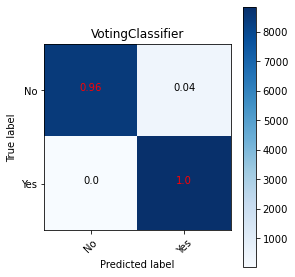

In [25]:
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score #( X_train_PCA , label)
from sklearn.metrics import f1_score
skf = StratifiedKFold(n_splits=5)

b_xgb_model=BaggingClassifier( **best_parameters_bagging['xgb'] )
b_clf_KNC  =BaggingClassifier( **best_parameters_bagging['knc'] )
b_clf_RFC  =BaggingClassifier( **best_parameters_bagging['rfc'] )
b_svc      =BaggingClassifier( **best_parameters_bagging['svc'] )
b_clf_gbc  =BaggingClassifier( **best_parameters_bagging['gbc'] )
b_etc      =BaggingClassifier( **best_parameters_bagging['etc'] )

best_parameters_vc = defaultdict(list)
weights = [1,1,1,1,1,1]


model_VC = VotingClassifier (estimators=[ ('xgb', b_xgb_model), ('knc', b_clf_KNC),('rfc',b_clf_RFC),('svc',b_svc),('gbc',b_clf_gbc),('etc',b_etc)], voting='hard', weights=weights,n_jobs=-1)
model_VC.fit(X_train,y_train)
y_pred = model_VC.predict(X_train)

print('F1 Score for Voting model = {}'.format(f1_score(y_train, y_pred, average='macro')))
plot_confusion_matrix(y_true=y_train, y_pred=y_pred, class_names=['No', 'Yes'],title="VotingClassifier",normalize=True,size=4)


<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [64]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler,MinMaxScaler

# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')
    

In [71]:
#df_local = pd.concat([df_temp_acep,df_temp_sosp])
pretraindata = PreTrainData(target = 'OBJETIVO')
df_local = pretraindata.fit(df, minNan2drop=3)
print(len(df_local['OBJETIVO']))

print("#############################")

transformData = TransformData(n_components=10,target='OBJETIVO')
transformData.fit(df_local.drop(columns=['OBJETIVO']),df_local['OBJETIVO'])
aaa = transformData.transform( df_local.drop(columns=['OBJETIVO']) )
print(aaa.shape)

Sospechoso    5020
Aceptado      5020
Name: OBJETIVO, dtype: int64
10040
#############################
(10040, 10)


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier



pipeline_input = df[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df['OBJETIVO']

X_train, X_test, y_train, y_test = train_test_split(
    pipeline_input,
    pipeline_target,
    test_size=0.8,
    random_state=27,
    stratify=pipeline_target,
)

#df_local = X_train.join(y_train)


#df_temp_acep = df.loc[df['OBJETIVO' ]=='Aceptado']#.dropna(thresh=len(df.columns)-0)
#df_temp_sosp = df.loc[df['OBJETIVO' ]=='Sospechoso']

#df_local = pd.concat([df_temp_acep,df_temp_sosp])
pretraindata = PreTrainData(target = 'OBJETIVO')
df_local = pretraindata.fit(df, minNan2drop=3)


transformData = TransformData(n_components=10,target='OBJETIVO')
############### PIPELINE

# Creación de nuestro para almacenamiento en Watson Machine Learning:
my_pipeline = Pipeline(
    steps=[
        ('preproces_transform', transformData),

        ('modelo_BaggingClassfier', model_VC),
    ]
)

my_pipeline.fit(df_local.drop(columns=['OBJETIVO']),df_local['OBJETIVO'])


Aceptado      8873
Sospechoso    8873
Name: OBJETIVO, dtype: int64


Pipeline(steps=[('preproces_transform',
                 TransformData(n_components=10, target='OBJETIVO')),
                ('modelo_BaggingClassfier',
                 VotingClassifier(estimators=[('xgb',
                                               BaggingClassifier(base_estimator=XGBClassifier(base_score=None,
                                                                                              booster=None,
                                                                                              colsample_bylevel=None,
                                                                                              colsample_bynode=None,
                                                                                              colsample_bytree=0.5,
                                                                                              gamma=None,
                                                                                              gpu_id=None,
          

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.976\nPrecision=0.957\nRecall=0.997\nF1 Score=0.976')

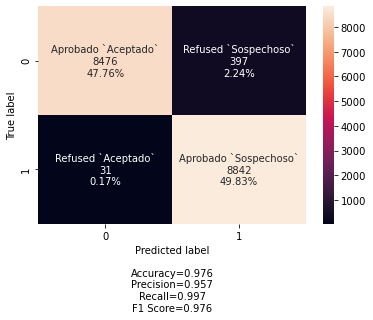

In [28]:
from sklearn.metrics import confusion_matrix

y_pred = my_pipeline.predict(df_local.drop(columns=['OBJETIVO']))
cf_matrix = confusion_matrix(df_local['OBJETIVO'], y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [80]:
cf_matrix[:,1]

array([400, 418])

In [76]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

0.822459093034128

In [ ]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    columns=["CXC", "CXP"]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
)

print(rm_columns)

In [ ]:
# Ver las columnas del conjunto de datos original
print("Columnas del conjunto de datos original: \n")
print(df.columns)

# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 = pd.DataFrame.from_records(
    data=rm_columns.transform(X=df)
)

# Ver las columnas del conjunto de datos transformado
print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df2.columns)

#### Transformación 2: estandarización de Features

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

#### División en 80% entrenamiento y 20% pruebas

#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [ ]:
# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='constant',  # la estrategia elegida es cambiar el valor faltante por una constante
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)

print(si)

In [ ]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df2)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df2.columns  # las columnas originales deben conservarse en esta transformación
)

# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.isnull().sum(axis = 0)))

In [ ]:
# Definiendo las variables features y target (removed CXC and CXP)

features = df3[
    [
        'EFECTIVO',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]
target = df3["OBJETIVO"]  ## No cambie la variable target!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None, stratify = target)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Entrenando un modelo ``DecisionTreeClassifier()``

In [ ]:
# Método para creacion de modelos basados en arbol de desición
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=3)
model = dtc.fit(X_train, y_train)

#### Haciendo una predicción con el set de prueba

In [ ]:
y_pred = dtc.predict(X_test)
print(y_pred)

#### Analizar la calidad del modelo a través de la matriz de confusión

In [ ]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo.

<hr>

### Construcción del Pipeline completo para el encapsulamiento en WML

#### Preparando transformaciones personalizadas para cargar en WML

En el reto 2 (Tortuga Code), se mostró cómo crear una transformación personalizada, declarando una clase Python con los métodos ``fit`` y ``transform``.

    - Código de transformación personalizada DropColumns():
    
    from sklearn.base import BaseEstimator, TransformerMixin
    # All sklearn Transforms must have the `transform` and `fit` methods
    class DropColumns(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            # Primero copiamos el dataframe de entrada 'X' de entrada
            data = X.copy()
            # Devolvemos un nuevo marco de datos sin las columnas no deseadas
            return data.drop(labels=self.columns, axis='columns')

Para integrar estos tipos de transformaciones personalizadas con Pipelines en Watson Machine Learning, primero debe empaquetar su código personalizado como una biblioteca de Python. Esto se puede hacer fácilmente usando la herramienta *setuptools*.

En el siguiente repositorio de git: https://github.com/vnderlev/sklearn_transforms tenemos todos los archivos necesarios para crear un paquete de Python, llamado **my_custom_sklearn_transforms**.
Este paquete tiene la siguiente estructura de archivos:

    /my_custom_sklearn_transforms.egg-info
        dependency_links.txt
        not-zip-safe
        PKG-INFO
        SOURCES.txt
        top_level.txt
    /my_custom_sklearn_transforms
        __init__.py
        sklearn_transformers.py
    PKG-INFO
    README.md
    setup.cfg
    setup.py
    
El archivo principal, que contendrá el código para nuestras transformaciones personalizadas, es el archivo **/my_custom_sklearn_transforms/sklearn_transformers.py**. Si accedes a él en el repositorio, notarás que contiene exactamente el mismo código declarado en el primer paso (la clase DropColumns).

Si has declarado sus propias transformaciones (además de la DropColumn proporcionada), debes agregar todas las clases de esas transformaciones creadas en este mismo archivo. Para hacer esto, debes hacer fork de este repositorio (esto se puede hacer en la propia interfaz web de Github, haciendo clic en el botón como se muestra en la imagen a continuación) y agregue sus clases personalizadas al archivo **sklearn_transformers.py**.

![alt text](https://i.imgur.com/2lZ4Ty2.png "forking-a-repo")

Si solo hizo uso de la transformación proporcionada (DropColumns), puede omitir este paso de fork y continuar usando el paquete base provisto. :)

Después de preparar su paquete de Python con sus transformaciones personalizadas, reemplace el enlace del repositorio de git en la celda a continuación y ejecútelo. Si no ha preparado ninguna transformación nueva, ejecute la celda con el enlace del repositorio ya proporcionado.

<hr>
    
**OBSERVACIÓN**

Si la ejecución de la celda a continuación devuelve un error de que el repositorio ya existe, ejecute:

**!rm -r -f sklearn_transforms**

In [ ]:
# Susbtituya el link de abajo por el link de su repositorio git (se es necesario)
!git clone https://github.com/vnderlev/sklearn_transforms.git

In [ ]:
!cd sklearn_transforms && ls -ltr

Para subir o código no WML, precisamos enviar um arquivo .zip com todo o código fonte, então iremos zipar o diretório clonado em seguida:

In [ ]:
!zip -r sklearn_transforms.zip sklearn_transforms

Con el archivo zip de nuestro paquete cargado en el Kernel de este notebook, podemos utiliar la herramienta pip para instalarlo conforme a la siguiente celda:

In [ ]:
!pip install sklearn_transforms.zip

Ahora podemos realizar la importación de nuestro paquiete personalizado en nuestro notabook!

Vamos a importan la transformación DropColumns. Si usted posee otras transformaciones personalizadas, ahora es que debe importarlas

In [ ]:
from my_custom_sklearn_transforms.sklearn_transformers import DropColumns

## Construyendo el model Pipeline

# ATENCIÓN, NO CAMBIE LA CELDA DE ABAJO O SU MODELO NO SERA EVALUADO

In [4]:
pipeline_input = df[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df['OBJETIVO']

In [ ]:
# Separación de los datos en un set de entrenamiento y otro de prueba (PARA CREACION DEL PIPELINE)
X_train, X_test, y_train, y_test = train_test_split(
    pipeline_input,
    pipeline_target,
    test_size=0.3,
    random_state=21233,
    stratify=pipeline_target,
)

### Borrando las columnas del dataset original

Debe elminiar todas las columnas que no esta usando

In [ ]:
# Creacion de la Transformación Personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=['CXC', 'CXP']
)

### Reemplazando con zeros en lugar de valores nulos

Ud puede usar otras estrategias, pero deben ser con Transforms

In [ ]:
# Crear un objeto ``SimpleImputer``

si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='constant',  # la estrategia elegida es cambiar el valor faltante por una constante (Ejemplo)
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)

### Estandarizando los valores numericos

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

### Pre-entrenando el modelo para definir el pipeline

En la celda de abajo se declara un objeto **Pipeline** de scikit-learn, donde es declarado como parametros *steps*, que es una lista de etapas a ejecutar el pipeline:

    'paso_1_remove_cols'     - Transformación personalizada DropColumns
    'paso_2_imputer'         - Transformación embebida de scikit-learn para remplazar los valores faltantes
    'paso_3_standard_scaler'          - Transformación embebida de scikit-learn para escalar las variables numéricas
    'su_modelo'              - Un árbol de desición simple
    
Note que pasamos como pasos las transformaciones instanciadas anteriormente, con nombres `rm_columns` y `si`.

In [ ]:
# Creación de nuestro para almacenamiento en Watson Machine Learning:
my_pipeline = Pipeline(
    steps=[
        ('paso_1_remove_cols', rm_columns),
        ('paso_2_imputer', si),
        ('paso_3_standard_scaler', sc),
        ('su_modelo', DecisionTreeClassifier(max_depth=3)),
    ]
)

En seguida ejecutaremos el método `fit()` del Pipeline, realizando el pré-procesamiento y el entrenamiento del modelo de una sola vez.

In [ ]:
# Inicializando el Pipeline (pre-procesamiento y entrenamiento del modelo)
my_pipeline.fit(X_train, y_train)

In [ ]:
### Haciendo una predicción con el set de prueba

y_pred = my_pipeline.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [ ]:
# Precisión simple
my_pipeline.score(X_test, y_test)

Ahora que tenemos un Pipeline completo, con etapas de pre-procesamiento configuradas y tambien un modelo por Árbol de Desición entrenado, podemos realizar la integración con Watson Machine Learning!

<hr>

### Encapsulando un Pipeline personalizado de Watson Machine Learning

#### Estableciendo conexión entre el cliente Python de WML y su instancia del servicio en la nube

In [ ]:
!rm -r WMLC_mod -f
!git clone https://github.com/DavidCastilloAlvarado/WMLC_mod.git
!zip -r watson_machine_learning_client_mod.zip WMLC_mod
!pip install watson_machine_learning_client_mod.zip

In [ ]:
# Biblioteca Python con implementación de un cliente HTTP para la API de WML
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Las próximas celdas realizaran el despliegue del pipeline declarada en este notebook en WML. Solo prosiga si usted ya está satisfecho con su modelo y cree que ya es hora de hacer el despliegue de su solución.

Copie las credenciales de su instancia de Watson Machine Learning en la variable de la celda de abajo.

Es importante que la variable que contenga los valores de la credencial se llame ``wml_credentials`` para que las proximas celdas de este notebook se ejecuten corretamente.

In [ ]:
wml_credentials = {
    "instance_id":"",
  "apikey": "dPoaJ1H9KN8kC2-xYj_N48beLXG9SAcXffls3x-cMAhj",
  "iam_apikey_description": "Auto-generated for key a41689c6-8075-4bb4-b51b-61bfb88b1368",
  "iam_apikey_name": "Auto-generated service credentials",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/2673a5220da64e36902b5e85a921bae2::serviceid:ServiceId-058227ac-c1ae-48ec-8d79-84ff94a864a1",
  "url": "https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/474ed705-6893-4c7b-b09e-f997fd17d734"
}

In [ ]:
# Instanciando un objeto cliente de Watson Machine Learning a partir de las credenciales

clientWML = WatsonMachineLearningAPIClient(wml_credentials)

In [ ]:
# Extrayendo los detalles de su de Watson Machine Learning

instance_details = clientWML.service_instance.get_details()
print(json.dumps(instance_details, indent=4))

**¡¡ATENCIÓN!!**

¡Este atento de los limites de consumo de su instancia de Watson Machine Learning!

En caso de que acabe la capa gratuita, no sera posible evualuar su modelo (Pues es necesario para la realización de algunas llamadasal API con sus predicciones!)

#### Listando todos los artefatos almacenados en su WML

Para listar todos los artefatos almacenados en su Watson Machine Learning, usted puede usar la seguinte función:

    clientWML.repository.list()

In [ ]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

## ATENCIÓN!, SI UD CORRE LAS CELDAS DE ABAJO TODOS LOS DESPLIEGUES ANTERIORS SERAN BORRADOS

In [ ]:
#Celda para borrar los Deployments:

for uid in clientWML.deployments.get_uids():
    if clientWML.deployments.get_details(uid)['entity']['name'] == 'deployment_meta_4' : 
        print('Deleted ' + clientWML.deployments.get_details(uid)['entity']['name'] )
        clientWML.deployments.delete(uid)

In [ ]:
#Celda para borrar todos los recursos:

d = clientWML.repository.get_details()
for k in d:
    for res in d[k]["resources"]:
        if res['entity']['name'] in ['package_meta_4', 'runtime_meta_4', 'pipeline_meta_4']:
            clientWML.repository.delete(res["metadata"]["guid"])
            print('Deleted ' + res['entity']['name'])

In [ ]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

#### Creando una nueva definición de paquete Python personalizado en WML

El primer paso para realizar su deploy y almacenar el código de las transformaciones personalizadas creadas por usted.

Para esta etapa solo necesitamos el archivo .zip del paquete creado por usted (Que ya tenemos cargados en el Kernel!)

In [ ]:
# Definición de metadatos del paquete con las Transformaciones personalizadas
pkg_meta = {
    clientWML.runtimes.LibraryMetaNames.NAME: "package_meta_4",
    clientWML.runtimes.LibraryMetaNames.DESCRIPTION: "A custom sklearn transform package",
    clientWML.runtimes.LibraryMetaNames.FILEPATH: "sklearn_transforms.zip",  # Note que estamos utilizando o .zip criado anteriormente!
    clientWML.runtimes.LibraryMetaNames.VERSION: "1.0",
    clientWML.runtimes.LibraryMetaNames.PLATFORM: { "name": "python", "versions": ["3.6"] }
}
custom_package_details = clientWML.runtimes.store_library( pkg_meta )
custom_package_uid = clientWML.runtimes.get_library_uid( custom_package_details )

print("\n Lista de artefactos de runtime almacenados en WML:")
clientWML.repository.list()

#### Creando una nueva definición de runtime Python personalizado en WML

El segundo paso es almacenar una definición de runtime Python para utilizar en nuestra biblioteca personalizada.

Esto puede hacerse de la siguiente manera:

In [ ]:
runtime_meta = {
    clientWML.runtimes.ConfigurationMetaNames.NAME: "runtime_meta_4",
    clientWML.runtimes.ConfigurationMetaNames.DESCRIPTION: "A Python runtime with custom sklearn Transforms",
    clientWML.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.6"
    },
    clientWML.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [ custom_package_uid ]
}
runtime_details = clientWML.runtimes.store( runtime_meta )
custom_runtime_uid = clientWML.runtimes.get_uid( runtime_details )

print("\n Detalles del runtime almacenados:")
print(json.dumps(runtime_details, indent=4))

In [ ]:
# Listando todos los runtimes almacenados en su WML:
clientWML.runtimes.list()

#### Creando una nueva definición de Pipeline personalizado en WML

Finalmente creando una definición (metadatos) para que nuestro Pipeline sea hospedada en WML.

Definimos como parametros el nombre para el artefacto y el ID de runtime creado anteriormente.

In [ ]:
model_meta = {
    clientWML.repository.ModelMetaNames.NAME: 'pipeline_meta_4',
    clientWML.repository.ModelMetaNames.DESCRIPTION: "my pipeline for submission",
    clientWML.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid
}

En seguida llamamos el método para almacenar una nueva definición:

In [ ]:
# Función para almacenar una definición de Pipeline en WML
stored_model_details = clientWML.repository.store_model(
    model=my_pipeline,  # `my_pipeline` es la variable creada anteriormente que contiene nuestro Pipeline ya entrenado :)
    meta_props=model_meta,  # Metadatos definidos en la celda anterior
    training_data=None  # No altere este parametro
)

print("\n Lista de artefatos almacenados en WML:")
clientWML.repository.list()

# Datalles del modelo hospedado en Watson Machine Learning
print("\n Metadatos del modelo almacenado:")
print(json.dumps(stored_model_details, indent=4))

#### Realizando un deployment de su modelo para consumo inmediato por otras aplicaciones

In [ ]:
# El deployment del modelo es finalmente realizado por medio del método ``deployments.create()``

model_deployment_details = clientWML.deployments.create(
    artifact_uid=stored_model_details["metadata"]["guid"],  # No altere este parametro
    name="deployment_meta_4",
    description="Desafio 4 MBTC",
    asynchronous=False,  # No altere este parametro
    deployment_type='online',  # No altere este parametro
    deployment_format='Core ML',  # No altere este parametro
    meta_props=model_meta  # No altere este parametro
)

#### Probando el modelo hospedado en Watson Machine Learning

In [ ]:
# Recuperando la URL endpoint dl modelo hospedado en la celda anterior

model_endpoint_url = clientWML.deployments.get_scoring_url(model_deployment_details)
print("La URL de llamada de su API es: {}".format(model_endpoint_url))

### ATENCIÓN: UD necesitará de la URL de arriba para entregar su modelo :)

In [ ]:
# Detalles del deployment realizado

deployment_details = clientWML.deployments.get_details(
    deployment_uid=model_deployment_details["metadata"]["guid"]  # Este es el ID de su deployment!
)

print("Metadatos del deployment realizado: \n")
print(json.dumps(deployment_details, indent=4))

### Realizando una llamada de API para su modelo almacenado en WML

In [ ]:
scoring_payload = {
    'fields': [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ],
    'values': [
        [
            968866.8993,
            102102.000,
            8539205.63,
            3898282.548,
            416873.3265,
            1420050.089,
            -629717.8548,
            14613560.64,
            7620711.462,
            116647.7396,
            1798064.624,
            9535423.826,
            3657339.603,
            770284.5004,
            -102101.201,
            -711032.0155
        ]
    ]
}

print("\n Payload de datos a ser clasificado:")
print(json.dumps(scoring_payload, indent=4))

In [ ]:
result = clientWML.deployments.score(
    model_endpoint_url,
    scoring_payload
)

print("\n Resultados:")
print(json.dumps(result, indent=4))

<hr>

## ¡Felicitaciones! 

Si todo fue ejecutado sin errores, ¡usted ya tiene un predictor basado en clasificacíon binaria encapsulado como una API REST!

Para enviar su solución, accede a la página:

# https://compusoluciones.maratona.dev

Usted necesitará del endpoint url de su modelo y las credenciales de WML :)